In [1]:
import os
import json
import pandas as pd
import utils
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.cm as cm

[nltk_data] Downloading package wordnet to /home/omar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/omar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2021-04-11 01:31:57,018 loading file /home/omar/.flair/models/sentiment-en-mix-distillbert_4.pt


## Define Topics

In [2]:
topics = sorted(["condition",
"lighting",
"customer service",
"trash",
"cleanliness",
"packages",
"noise",
"grounds",
"landscaping",
"maintenance",
"financial",
"move",
"pests",
"covid",
"apartment",
"community",
"security"])

## Read Topics/keywords json file

In [3]:
with open('keywords.json') as f:
  topics_vs_keywords = json.load(f)

## Read data files

In [4]:
df_frames = []
for file in os.listdir("./data"):
    if file.endswith(".csv"):
        df_frames.append(pd.read_csv(f"./data/{file}"))

data = pd.concat(df_frames) 
data.head()

,DATE,PROPERTYID,REVIEWID,PROPERTY NAME,REVIEW SITE,COMPANY NAME,ACTUAL REVIEW,REVIEWER NAME,STAR RATING
0,1/22/2021,JTA037190,1901372.0,Colonial Grand at Godley Station,google,MAA,NaN,Ricardo Dones-Santana,5
1,1/22/2021,JTA046759,1901383.0,Rivers Walk,google,MAA,NaN,Ceicily CiCi,5
2,1/22/2021,JTA040998,1901373.0,Colonial Grand at Silverado Reserve,google,MAA,NaN,Kristen Stevens,4
3,1/22/2021,JTA005849,1901376.0,Grand Reserve at Pinnacle,google,MAA,NaN,Marquita Davis,5
4,1/22/2021,JTA046575,1901381.0,Post Fallsgrove,google,MAA,NaN,K Dixon,5


In [5]:
## remove nulls from dataset
filtered_data = data[ (data["ACTUAL REVIEW"].notnull()) & (data["ACTUAL REVIEW"]!=u'') ]
print(f"Size of dataset: {len(filtered_data)}")

Size of dataset: 13484


### Data preprocessing and preparation

In [6]:
filtered_data["processed_review"] = filtered_data["ACTUAL REVIEW"].apply(lambda x: utils.detect_language_and_translate(x.lower()))

## preprocess text (and removing stopwords)
filtered_data["clean_review"] = filtered_data["processed_review"].apply(lambda x: utils.preprocess_text(x,remove_stopwords = True))

## preprocess text (Keeping stopwords)
filtered_data["clean_actual_review"] = filtered_data["processed_review"].apply(lambda x: utils.preprocess_text(x,remove_stopwords = False))

<ipython-input-6-11cd01304c3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["processed_review"] = filtered_data["ACTUAL REVIEW"].apply(lambda x: utils.detect_language_and_translate(x.lower()))
<ipython-input-6-11cd01304c3e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["clean_review"] = filtered_data["processed_review"].apply(lambda x: utils.preprocess_text(x,remove_stopwords = True))
<ipython-input-6-11cd01304c3e>:7: SettingWithCopyWarning: 
A value is trying to be set on

### Visualizing Common Words using WordCloud

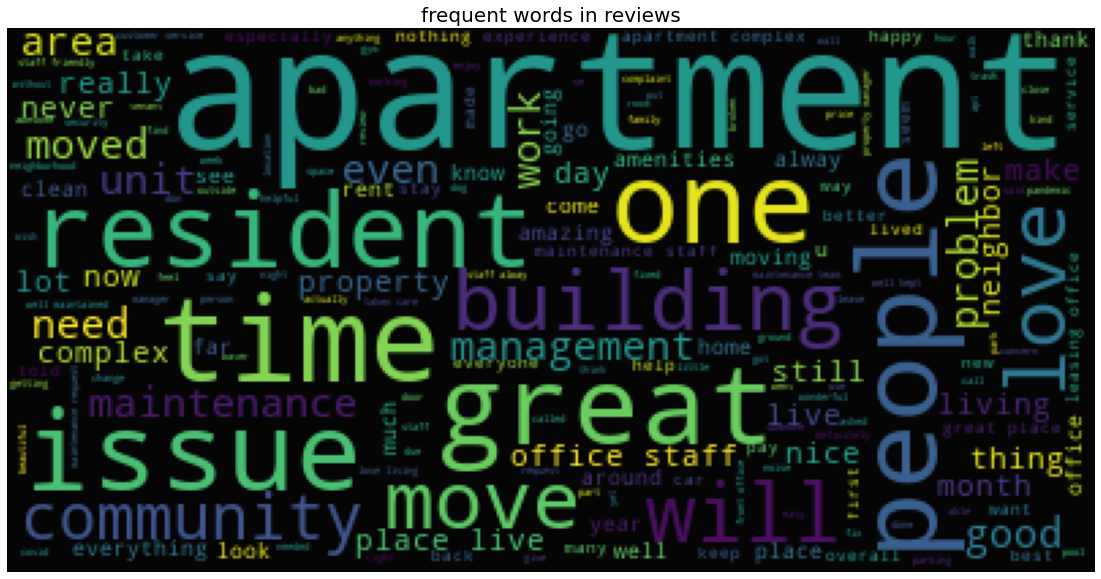

In [7]:
text = filtered_data["clean_review"].values
wc = WordCloud(background_color="black",stopwords=  utils.stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("frequent words in reviews", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [8]:
## manipulate topics_vs_keywords dict
keyword_vs_topics = {}
for key, value in topics_vs_keywords.items():
    for v in value:
        keyword_vs_topics[v] = keyword_vs_topics.get(v,set())
        keyword_vs_topics[v].add(key)

keywords = list(keyword_vs_topics.keys())

In [9]:
filtered_data["topics"] = filtered_data["clean_review"].apply(lambda x: utils.extract_topics(x,keywords,topics, keyword_vs_topics)[0])
filtered_data["indices"] = filtered_data["clean_review"].apply(lambda x: utils.extract_topics(x,keywords,topics, keyword_vs_topics)[1])
filtered_data["sentiment"] = filtered_data["clean_actual_review"].apply(lambda x: utils.predict_sentiment(x))

<ipython-input-9-9d7f699f98da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["topics"] = filtered_data["clean_review"].apply(lambda x: utils.extract_topics(x,keywords,topics, keyword_vs_topics)[0])
<ipython-input-9-9d7f699f98da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["indices"] = filtered_data["clean_review"].apply(lambda x: utils.extract_topics(x,keywords,topics, keyword_vs_topics)[1])
<ipython-input-9-9d7f699f98da>:3: SettingWithCopyWarning: 
A value is trying to b

### Example for model performance on one example

In [10]:
index = 46
print(f'Sentence: {filtered_data[filtered_data.index==index]["clean_actual_review"].values[0]}','\n')
print(f'Extracted topics:{filtered_data[filtered_data.index==index]["topics"].values[0]}','\n')
print(f'Extracted Sentiment:{filtered_data[filtered_data.index==index]["sentiment"].values[0]}', '\n')

Sentence: this is a very conveniently located well maintained community. the staff is very responsive and friendly. it ambiance is that of an owned home community and beyond compare in the area. my building has had significant turnover but each resident has been friendly and thoughtful. it is very pet friendly which is was a must for me but there is no onsite pet area. 

Extracted topics:['maintenance', 'community', 'customer service', 'apartment'] 

Extracted Sentiment:positive 



### Extract Reviews after categorization

In [11]:
filtered_data.to_csv("reviews_categorized.csv")

## Data Analysis and Visualization

## Analayze each of the following:
### 1) relationship between property and reviewers sentiment 
### 2) relationship between property and topics mentioned in related reviews

In [12]:
filtered_data = filtered_data.reset_index()

In [13]:
property_vs_sentimentfreqs, property_vs_categoriesfreqs = utils.get_counts(filtered_data,topics)

In [14]:
### create a dataframe containing (property_vs_sentimentfreqs and property_vs_categoriesfreqs)
df = pd.DataFrame.from_dict(property_vs_categoriesfreqs).T
df = df.join(pd.DataFrame.from_dict(property_vs_sentimentfreqs).T)

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

### Initialize multi-label binarizer

In [16]:
mlb = MultiLabelBinarizer() 

#transform the topics column to a series of columns with binary values
binary_labels=pd.DataFrame(mlb.fit_transform(filtered_data['topics']),columns=mlb.classes_) 

In [17]:
binary_labels.head()

,apartment,cleanliness,community,condition,covid,customer service,financial,grounds,landscaping,lighting,maintenance,move,noise,packages,pests,security,trash
0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0
2,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0
3,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


### Using Binary Labels to visualize topic occurrences in reviews

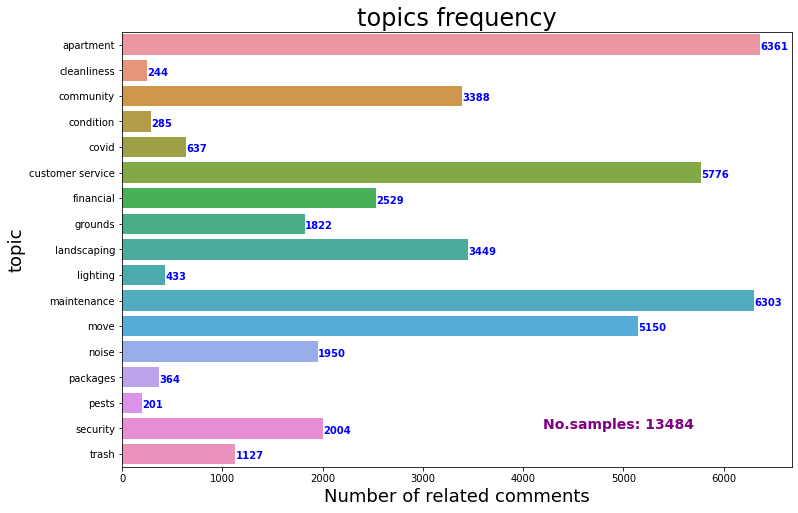

In [18]:
plt.figure(figsize=(12,8))
categories = list(binary_labels.columns.values)
ax= sns.barplot(binary_labels.sum().values, categories)

plt.title("topics frequency", fontsize=24)
plt.ylabel('topic', fontsize=18)
plt.xlabel('Number of related comments', fontsize=18)

#adding the text labels
rects = ax.patches
for i, v in enumerate(binary_labels.sum().values):
    ax.text(v + 3, i + .2, str(v), color='blue', fontweight='bold')

labels = binary_labels.sum().values
plt.text(4200, 15, f"No.samples: {len(filtered_data)}", size=14, color='purple', fontweight= "bold")
plt.show()

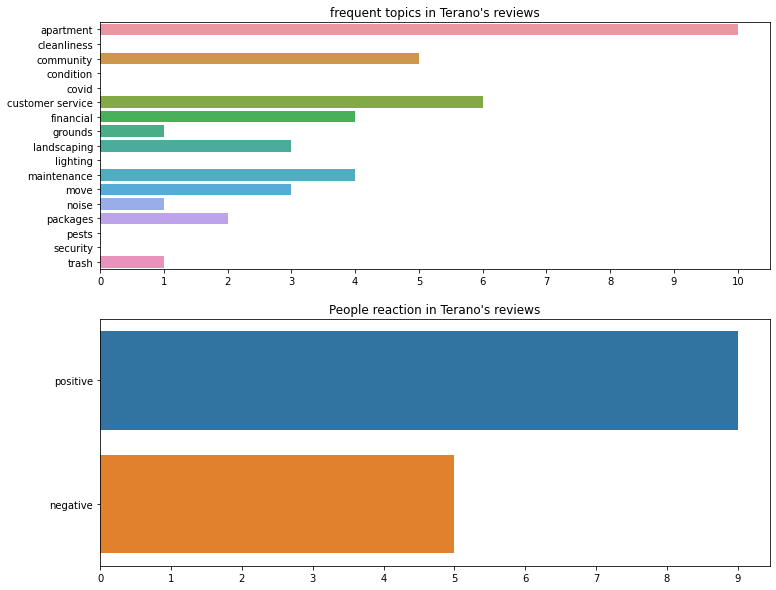

In [19]:
utils.plot_location_vs_topics_count(df,"Terano")